# Math 271.1: Exercise 2 (#4)

#### INSTRUCTION: Image Compression Using Singular Value Decomposition (SVD) <br>

(a) Compute the singular value decomposition A= UΣVT <br>
(b) Reconstruct the image using only the top k singular values <br>
(c) Display both the original and compressed images side by side.

#### Importing Libraries needed

We'll need:
- numpy for numerical computations
- matplotlib for image display
- PIL (Python Imaging Library) for image processing

In [116]:
import numpy as np
import matplotlib.pyplot as plt # for visualization
from PIL import Image  # Importing Image from PIL (Python Imaging Library)

#### Setting up and Loading the image

- Picked a black and white image from unsplash
- Load the image, convert it to grayscale, and resize
- Args:
    - image_path (str): Path to the image file
    - target_size (tuple): Desired output size (width, height)
- Image will then be a numpy.ndarray: grayscale image

In [117]:
# Path to the image
image_path = '../../data/external/images/sample_grayscale_img.jpg'
target_size=(512, 512)

img = Image.open(image_path)

# Print original image mode and format
print(f"Original image mode: {img.mode}")
print(f"Original image format: {img.format}")

# Convert to grayscale
img_gray = img.convert('L')
print(f"After conversion mode: {img_gray.mode}")

# Resize the image
img_resized = img_gray.resize(target_size, Image.Resampling.LANCZOS)

# Convert to numpy array with float64 and normalize to [0, 1]
img_array = np.array(img_resized, dtype=np.float64) / 255.0

print(f"\nArray dtype: {img_array.dtype}")
print(f"Value range: [{img_array.min():.3f}, {img_array.max():.3f}]")

Original image mode: RGB
Original image format: JPEG
After conversion mode: L

Array dtype: float64
Value range: [0.000, 1.000]


#### Displaying the image

- resized image to better enhance performance of the algorithm
- prints information of the resized image

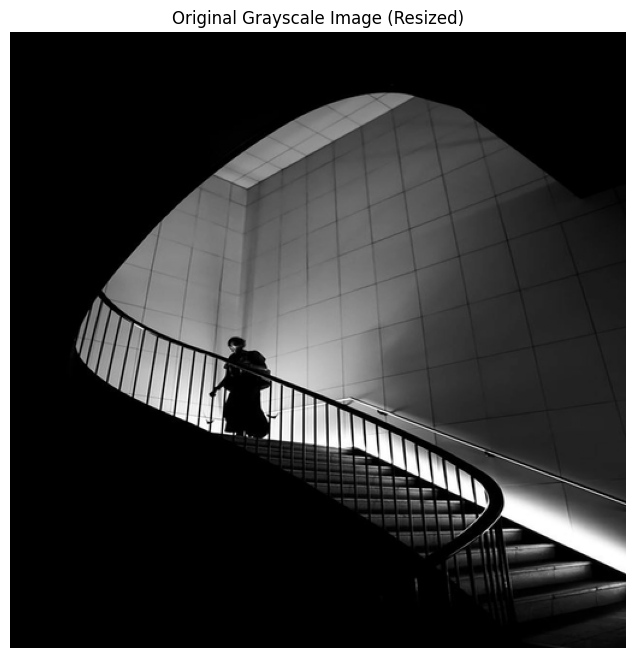

Image shape: (512, 512)
Data type: float64
Min pixel value: 0.0
Max pixel value: 1.0


In [118]:
# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(img_array, cmap='gray')
plt.axis('off')
plt.title('Original Grayscale Image (Resized)')
plt.show()

# Print image shape and information
print(f"Image shape: {img_array.shape}")
print(f"Data type: {img_array.dtype}")
print(f"Min pixel value: {img_array.min()}")
print(f"Max pixel value: {img_array.max()}")

### (a) Computing SVD

SVD decomposes a matrix A into three matrices: A = UΣV^T
- U: Left singular vectors (orthogonal matrix)
- Σ: Diagonal matrix of singular values
- V^T: Transposed right singular vectors (orthogonal matrix)

In [119]:
U, s, Vt = np.linalg.svd(img_array, full_matrices=False)
print(f"Shapes -> U: {U.shape}, s: {s.shape}, Vt: {Vt.shape}")

Shapes -> U: (512, 512), s: (512,), Vt: (512, 512)


#### Energy Analysis

- Calculates energy retention
- Calculate the k needed for 85% energy retention

In [120]:
# Find k for 85% energy
singular_values_squared = s**2
cumulative_energy = np.cumsum(singular_values_squared) / np.sum(singular_values_squared)

k = np.argmax(cumulative_energy >= 0.85) + 1
print(f"k = {k} for 85% energy retention")

k = 5 for 85% energy retention


Explores the energy captured at different k values

In [121]:
print("\nPercentage of energy captured:\n")

for k in [5, 10, 20, 50, 100]:
    print(f"First {k} singular values: {cumulative_energy[k-1]*100:.2f}%")


Percentage of energy captured:

First 5 singular values: 85.07%
First 10 singular values: 91.58%
First 20 singular values: 95.55%
First 50 singular values: 98.45%
First 100 singular values: 99.53%


### (b) Reconstruct image using only k singular values

- Demosntrates compression with k - 5
- Single compressed version specific for 85% energy retention

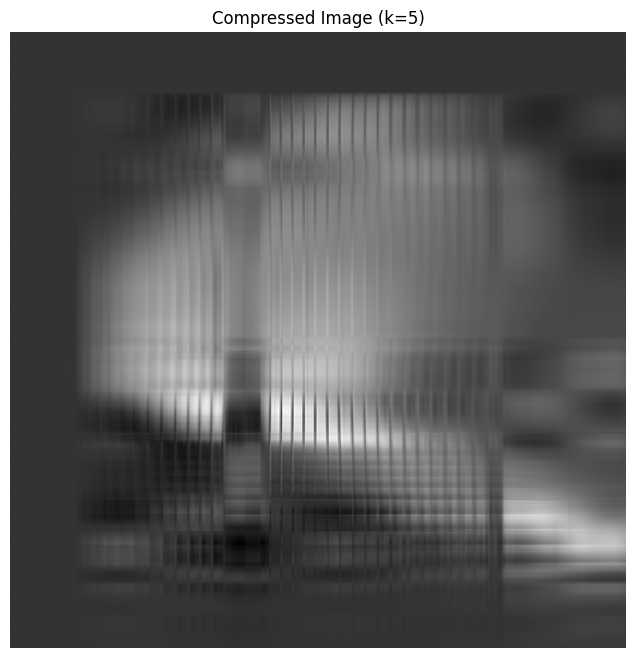

In [122]:
k = 5

# Reconstruct image
A_compressed = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]

plt.figure(figsize=(8, 8))
plt.imshow(A_compressed, cmap='gray')
plt.title(f'Compressed Image (k={k})')
plt.axis('off')
plt.show()

### (c) Display the image to compare between the original and the compressed at k = 5

- Displays original vs compressed
- Visual comparison

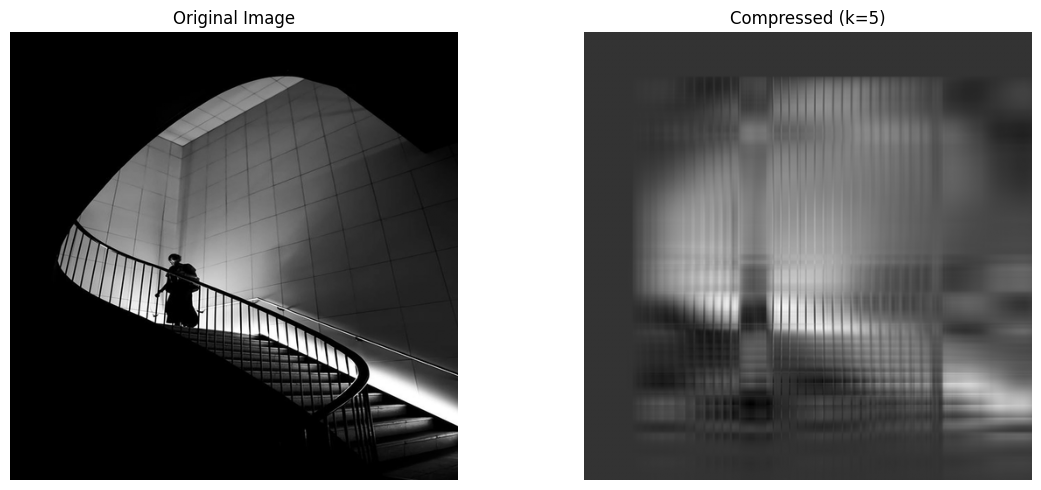

In [123]:
# Display
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_array, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(A_compressed, cmap='gray')
axes[1].set_title(f'Compressed (k={k})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

#### Reconstructing images by multiple k values

Out of curiosity I wanted to also see image compression by different k values

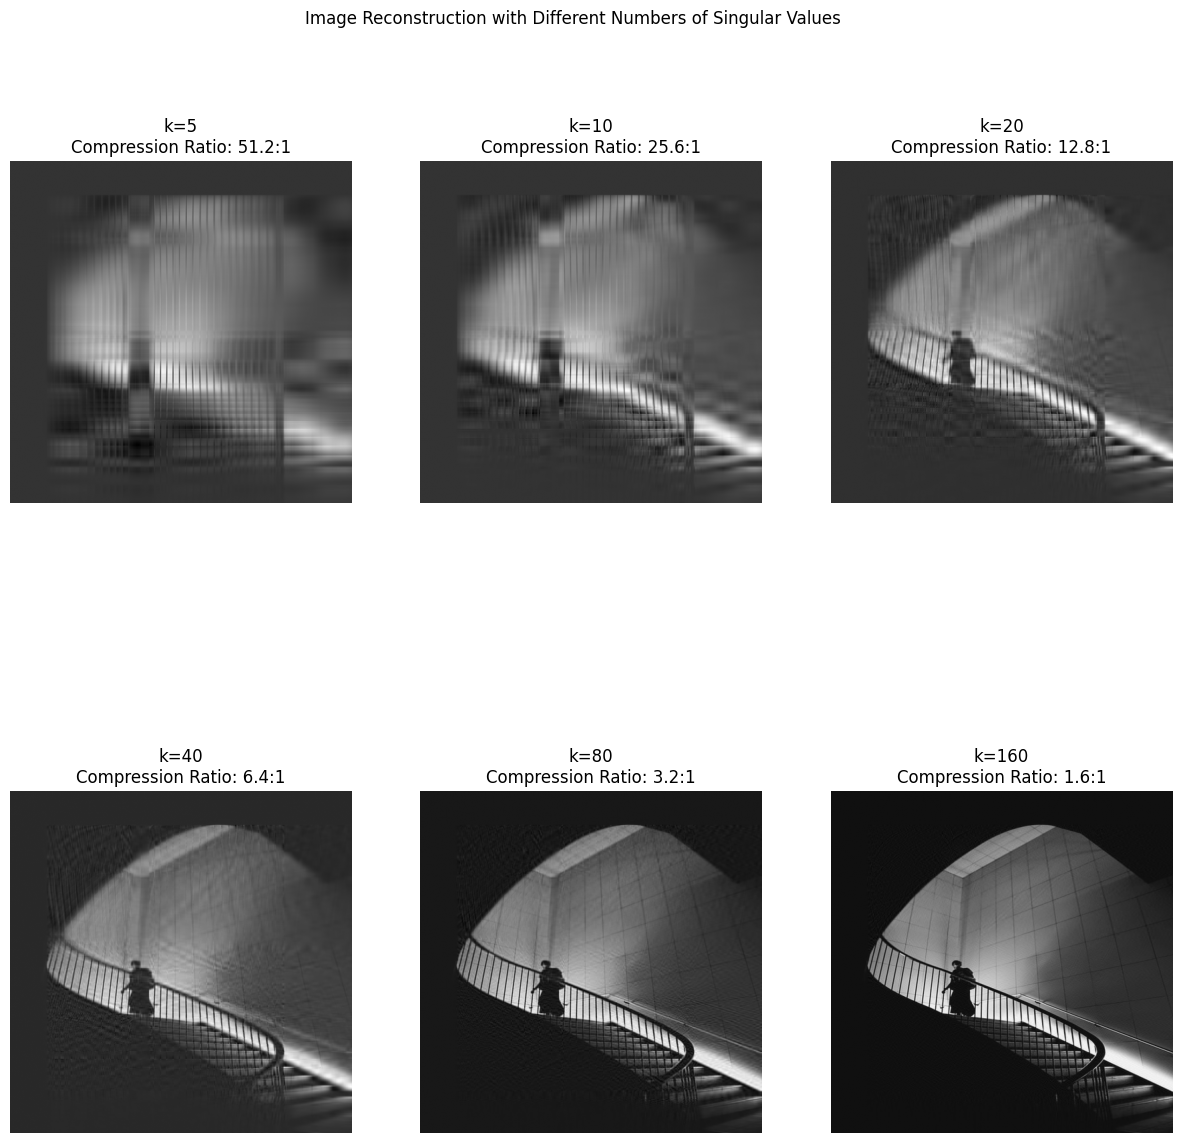

In [124]:
def reconstruct_image(U, s, Vt, k):
    """
    Reconstruct image using only k singular values

    Parameters:
    - U: Left singular vectors (m×m matrix)
    - s: Singular values (array of length min(m,n))
    - Vt: Right singular vectors transposed (n×n matrix)
    - k: Number of components to use (k <= rank(A))

    Returns:
    - reconstructed: Compressed image using k components
    """
    # Step 1: Create a k×k diagonal matrix from top k singular values
    S = np.zeros((k, k))
    np.fill_diagonal(S, s[:k])

    # Step 2: Matrix multiplication of reduced components
    # U[:, :k] -> m×k matrix (keep k columns)
    # S -> k×k diagonal matrix
    # Vt[:k, :] -> k×n matrix (keep k rows)
    reconstructed = U[:, :k] @ S @ Vt[:k, :]

    return reconstructed

# Test different compression levels with exponentially increasing k values
k_values = [5, 10, 20, 40, 80, 160]  # Each k is roughly double the previous
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.ravel()  # Convert 2D array of axes to 1D for easier indexing

for idx, k in enumerate(k_values):
    # Step 1: Reconstruct image with k components
    reconstructed = reconstruct_image(U, s, Vt, k)

    # Step 2: Calculate compression ratio
    original_size = img_array.shape[0] * img_array.shape[1]  # m×n pixels
    compressed_size = k * (img_array.shape[0] + img_array.shape[1] + 1)  # k(m + n + 1)
    compression_ratio = original_size / compressed_size

    # Step 3: Display the result
    axes[idx].imshow(reconstructed, cmap='gray')
    axes[idx].axis('off')
    axes[idx].set_title(f'k={k}\nCompression Ratio: {compression_ratio:.1f}:1')

plt.suptitle('Image Reconstruction with Different Numbers of Singular Values', y=0.92)
plt.show()

#### References/Sources:

- Photo by HIDDEN COUPLE: https://www.pexels.com/photo/person-walking-on-stairs-in-greyscale-photograph-3048527/